PROYECTO FIN DE MASTER UNIVERSIDAD INTERNACIONAL DE LA RIOJA: Análisis y segmentación del estilo de conducción vehicular

1. Recolección de Datos
   Datos obtenidos corresponden a un año de información de recorridos de 200 vehículos que disponen un dispostiivo IOT instalado que emite frecuentemente información

In [767]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from numpy import unique
from sklearn.cluster import AgglomerativeClustering


In [280]:
# Carga archivo csv del folder "dataset"
# Cada registro agrupa la cantidad de eventos generados durante el recorrido por vehículo
df = pd.read_csv("./dataset/drivingStyleDS.csv") 
print('Tamaño de la muestra: {}'.format(len(df)))
print("Número de dispositivos únicos: {}".format(len(df.Code.value_counts())))

Tamaño de la muestra: 281912
Número de dispositivos únicos: 200


In [281]:
# Muestra de la información
df.head()

,Code,tripDate,segmentOverSpeed,harshAcceleration,harshBraking,harshTurn,mileage,dayInterval,continuosDriving
0,XXXXX00001,7/10/2019 17:00,0,0,0,0,1.3,diurno,0
1,XXXXX00001,7/10/2019 16:00,1,0,0,0,4.9,diurno,0
2,XXXXX00001,7/9/2019 19:00,2,0,0,0,15.0,diurno,0
3,XXXXX00001,1/30/2020 13:00,4,0,0,0,9.0,diurno,0
4,XXXXX00001,1/29/2020 22:00,11,0,0,0,15.0,nocturno,0


In [282]:
# Muestra información estadística del Datamart
# En el caso particular no aparece el campo dayInterval por ser "categórico", posterior en la sección de feature engineering se transformará el dato
df.describe()

,segmentOverSpeed,harshAcceleration,harshBraking,harshTurn,mileage,continuosDriving
count,281912.000000,281912.000000,281912.000000,281912.000000,281912.000000,281912.000000
mean,5.502022,0.166396,0.035213,0.066751,9.433422,0.010056
std,15.374293,0.707724,0.957310,0.482394,25.546098,0.099776
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.600000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,4.100000,0.000000
75%,5.000000,0.000000,0.000000,0.000000,9.800000,0.000000
max,835.000000,45.000000,126.000000,34.000000,8706.800000,1.000000


In [283]:
# Muestra la distribución de las incidencias en función de la cantidad de vehículos únicos
dfByDevice = df.groupby('Code').agg({'segmentOverSpeed':'sum','harshAcceleration':'sum','harshBraking':'sum','harshTurn':'sum','mileage':'sum'})

In [284]:
dfByDevice

,segmentOverSpeed,harshAcceleration,harshBraking,harshTurn,mileage
Code,,,,,
XXXXX00001,12767,366,1,199,16676.5
XXXXX00002,4659,214,0,66,6583.4
XXXXX00003,2921,228,0,92,3886.1
XXXXX00004,8711,199,0,66,13672.2
XXXXX00005,2146,180,0,62,4026.0
...,...,...,...,...,...
XXXXX00196,6415,41,0,27,8568.9
XXXXX00197,16294,284,124,186,13842.2
XXXXX00198,11575,104,0,31,12139.4


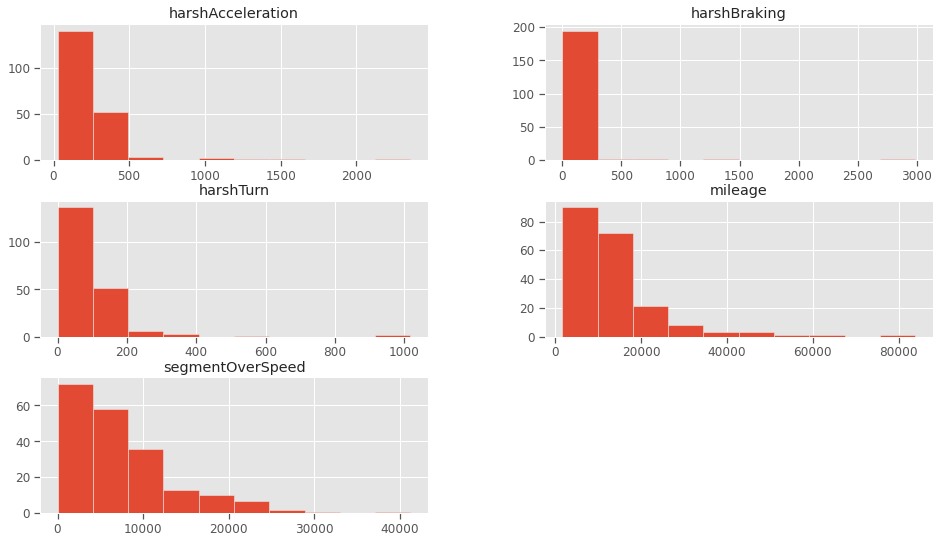

In [285]:
# Muestra distribución de las incidencias por cantidad de dispositivos
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
eventsHist = dfByDevice.hist()


2. Limpieza de Datos
   Se debe tomar en cuenta que no muchos modelos soportan valores vacios.

In [286]:
# Elimina valores vacios del dataset
print(df.isna().sum())
print(df.isnull().sum())


Code                 0
tripDate             0
segmentOverSpeed     0
harshAcceleration    0
harshBraking         0
harshTurn            0
mileage              0
dayInterval          0
continuosDriving     0
dtype: int64
Code                 0
tripDate             0
segmentOverSpeed     0
harshAcceleration    0
harshBraking         0
harshTurn            0
mileage              0
dayInterval          0
continuosDriving     0
dtype: int64


In [287]:
# En caso de que existan valores vacios
# df.fillna(df.mean(), inplace=True)


3. Feature Engineering
   Proceso de transformación de información

In [288]:
# Se parte de algunas definiciones importantes
# Todas las incidencias tendrán el mismo peso
# Todas las incidencias deben ser calculads de acuerdo a los kilómetros recorridos (No es lo mismo tener 1 evento cada km que 1 en 100km de recorrido)
# La variable categórica continuosDriving también tiene incidencia en el modelo. cuando esté en 1 se calculará como todo el kilometraje recorrido en ese intervalo

df['continuosDrivingMileage'] = df['mileage']*df['continuosDriving']
df.head()

,Code,tripDate,segmentOverSpeed,harshAcceleration,harshBraking,harshTurn,mileage,dayInterval,continuosDriving,continuosDrivingMileage
0,XXXXX00001,7/10/2019 17:00,0,0,0,0,1.3,diurno,0,0.0
1,XXXXX00001,7/10/2019 16:00,1,0,0,0,4.9,diurno,0,0.0
2,XXXXX00001,7/9/2019 19:00,2,0,0,0,15.0,diurno,0,0.0
3,XXXXX00001,1/30/2020 13:00,4,0,0,0,9.0,diurno,0,0.0
4,XXXXX00001,1/29/2020 22:00,11,0,0,0,15.0,nocturno,0,0.0


In [289]:
dfTraining = df.groupby('Code').agg({'segmentOverSpeed':'sum','harshAcceleration':'sum','harshBraking':'sum','harshTurn':'sum','continuosDrivingMileage':'sum','mileage':'sum'})

In [290]:
# Incidencias de acuerdo a los kilómetros recorridos
dfTraining['segmentOverSpeed'] = dfTraining['segmentOverSpeed'] / dfTraining['mileage']
dfTraining['harshAcceleration'] = dfTraining['harshAcceleration'] / dfTraining['mileage']
dfTraining['harshBraking'] = dfTraining['harshBraking'] / dfTraining['mileage']
dfTraining['harshTurn'] = dfTraining['harshTurn'] / dfTraining['mileage']
dfTraining['continuosDrivingMileage'] = dfTraining['continuosDrivingMileage'] / dfTraining['mileage']


In [291]:
# Eliminamos la variable 'mileage' que ya no tendría incidencia en el modelo
dfTraining = dfTraining.drop('mileage', 1)

In [294]:
dfTrainingTemplate = dfTraining
dfTraining.head()

,segmentOverSpeed,harshAcceleration,harshBraking,harshTurn,continuosDrivingMileage
Code,,,,,
XXXXX00001,0.765568,0.021947,0.00006,0.011933,0.098600
XXXXX00002,0.707689,0.032506,0.00000,0.010025,0.000000
XXXXX00003,0.751653,0.058671,0.00000,0.023674,0.114176
XXXXX00004,0.637132,0.014555,0.00000,0.004827,0.015974
XXXXX00005,0.533035,0.044709,0.00000,0.015400,0.095355


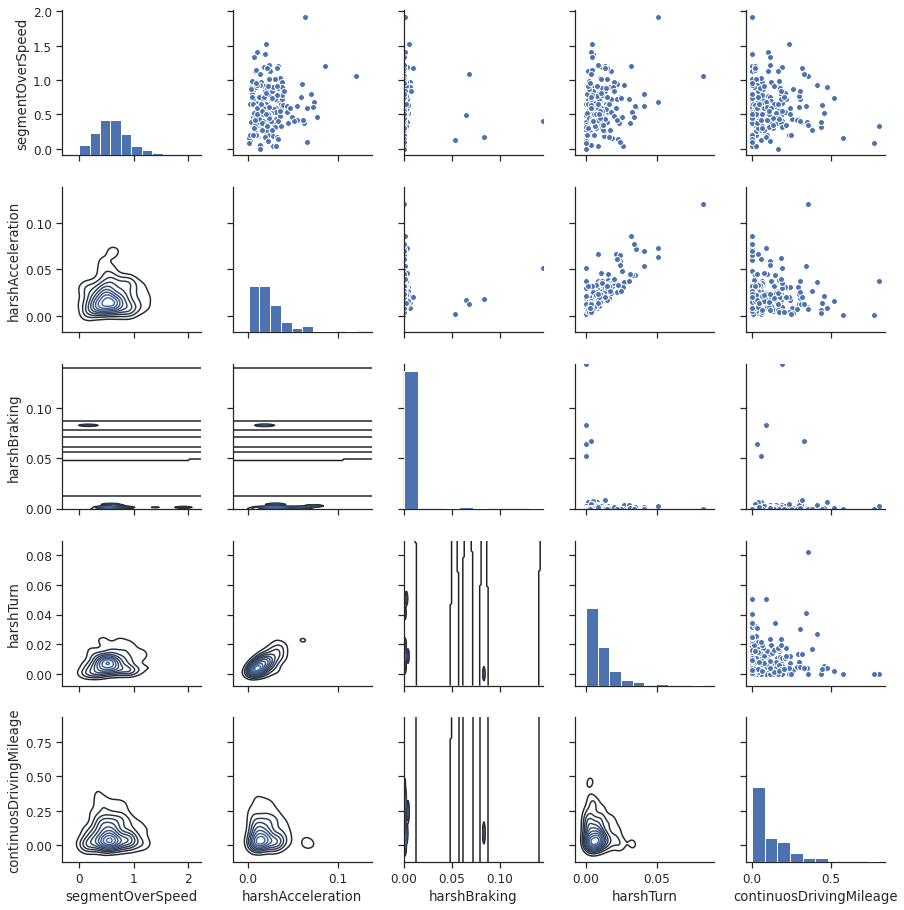

In [295]:
# Comparación en pares entre los atributos para Histograma, densidad y distribución
import seaborn as sns
sb.set(style="ticks",font_scale=1.1)
g = sb.PairGrid(dfTraining)
g = g.map_upper(plt.scatter, edgecolor="white")
g = g.map_lower(sb.kdeplot)
g = g.map_diag(plt.hist, edgecolor="white")

<Figure size 1152x648 with 0 Axes>

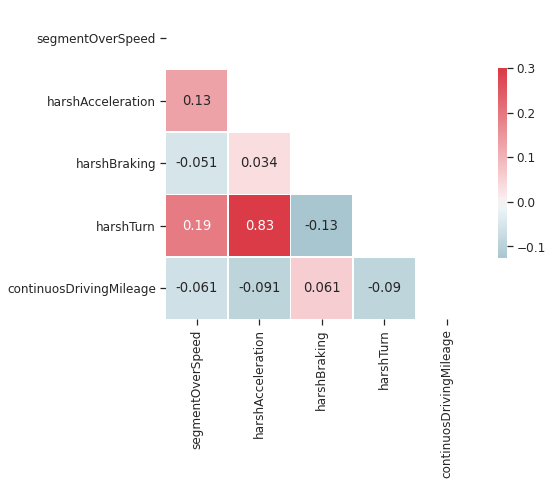

In [296]:
# Correlación entre incidenc
corr = dfTraining.corr()

# Máscara del triángulo superior
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig = plt.figure()

# Seteo de parámetros
f, ax = plt.subplots(figsize=(7, 7))

# Genera paleta de colores
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sb.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

In [297]:
dfTraining.describe()

,segmentOverSpeed,harshAcceleration,harshBraking,harshTurn,continuosDrivingMileage
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.609809,0.023182,0.002665,0.009993,0.117812
std,0.311611,0.018007,0.013865,0.010671,0.137407
min,0.000000,0.000594,0.000000,0.000000,0.000000
25%,0.398665,0.009858,0.000000,0.003292,0.020002
50%,0.587121,0.018596,0.000028,0.007343,0.068358
75%,0.795181,0.031635,0.000342,0.013099,0.170805
max,1.918250,0.120343,0.144125,0.081946,0.803534


In [298]:
# Estandarización de datos
#scaler = StandardScaler()
scaler =  MinMaxScaler()
dfScaled = scaler.fit_transform(dfTrainingTemplate)

# statistics of scaled data
dfTest = pd.DataFrame(dfScaled)
dfTest.describe()

,0,1,2,3,4
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.317899,0.188623,0.018494,0.121942,0.146617
std,0.162445,0.150372,0.096201,0.130220,0.171003
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.207827,0.077361,0.000000,0.040170,0.024893
50%,0.306071,0.150327,0.000193,0.089610,0.085071
75%,0.414534,0.259218,0.002370,0.159850,0.212567
max,1.000000,1.000000,1.000000,1.000000,1.000000


4. K-means Model
   Agrupa las observaciones en K clusters distintos

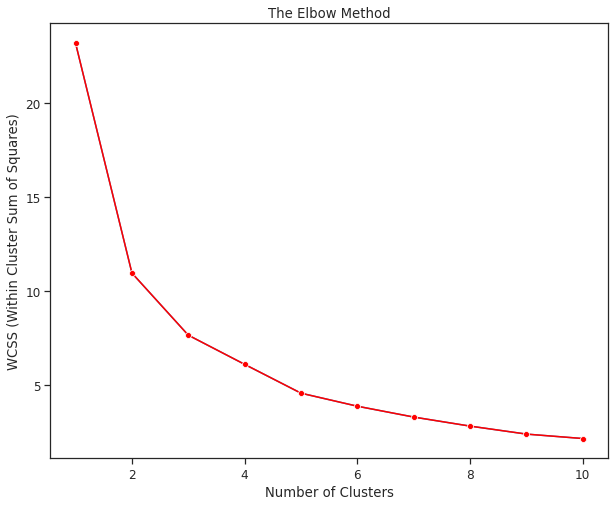

In [301]:
#Obtener el valor de k --> Curva de Elbow

fig = plt.figure(figsize=(10, 8))
withinClusterSumOfSquares = []
for i in range(1, 11):
    clf = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    clf.fit(dfTraining)
    withinClusterSumOfSquares.append(clf.inertia_) # inertia is another name for WCSS

plt.plot(range(1, 11), withinClusterSumOfSquares)
sb.lineplot(range(1, 11), withinClusterSumOfSquares,marker='o',color='red')
plt.title('The Elbow Method')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.xlabel('Number of Clusters')
plt.show()

In [156]:
# De acuerdo al resultado el número adecuado de clusters sería entre 3 a 5 (Cuando converge al eje X y se mantiene constante)
# K = 4

In [437]:
# Calcula el score a través del método silhouette
clusterRange = list (range(2,10))
for n in clusterRange:
    clusterer = KMeans(n_clusters=n)
    preds = clusterer.fit_predict(dfTraining)
    centers = clusterer.cluster_centers_

    score = silhouette_score(dfTraining, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n, score))

For n_clusters = 2, silhouette score is 0.6673483035092025)
For n_clusters = 3, silhouette score is 0.7495308274920259)
For n_clusters = 4, silhouette score is 0.820433633128811)
For n_clusters = 5, silhouette score is 0.7490950344991735)
For n_clusters = 6, silhouette score is 0.6516254737877493)
For n_clusters = 7, silhouette score is 0.4685683851561475)
For n_clusters = 8, silhouette score is 0.4522114283823524)
For n_clusters = 9, silhouette score is 0.44830595317422267)


In [ ]:
# Por este método el mayor score es k=4

In [316]:
# k = 4 clusters and k-means++ initialization
kmeans = KMeans(n_jobs = -1, n_clusters = 4, init='k-means++', max_iter=600)
kmeans.fit(dfTest)
predict = kmeans.predict(dfTest)

In [317]:
frame = dfTest
frame['cluster'] = predict
frame['cluster'].value_counts()

1    89
0    65
3    25
2    21
Name: cluster, dtype: int64

In [304]:
# resultado de la predicción
predict

array([0, 0, 1, 3, 3, 3, 1, 3, 0, 3, 3, 3, 2, 0, 0, 0, 0, 0, 3, 2, 1, 3,
       0, 0, 3, 0, 2, 3, 3, 0, 3, 3, 2, 1, 3, 2, 3, 3, 3, 3, 0, 3, 1, 3,
       0, 1, 3, 3, 0, 3, 1, 0, 0, 0, 3, 2, 3, 1, 2, 0, 0, 1, 3, 0, 3, 3,
       1, 3, 3, 3, 2, 3, 3, 3, 0, 0, 0, 0, 3, 3, 0, 2, 3, 3, 1, 3, 0, 3,
       2, 2, 3, 0, 3, 3, 2, 2, 0, 3, 2, 1, 3, 0, 0, 2, 0, 3, 3, 0, 3, 0,
       2, 2, 3, 0, 2, 0, 1, 2, 0, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 0,
       0, 3, 3, 0, 2, 3, 1, 3, 3, 0, 3, 1, 2, 0, 3, 0, 3, 0, 3, 3, 0, 3,
       3, 0, 0, 1, 0, 0, 2, 3, 0, 3, 3, 3, 0, 3, 2, 3, 1, 3, 3, 1, 2, 0,
       3, 3, 0, 1, 0, 2, 3, 3, 0, 0, 0, 3, 0, 1, 3, 3, 0, 3, 0, 0, 0, 0,
       3, 1], dtype=int32)

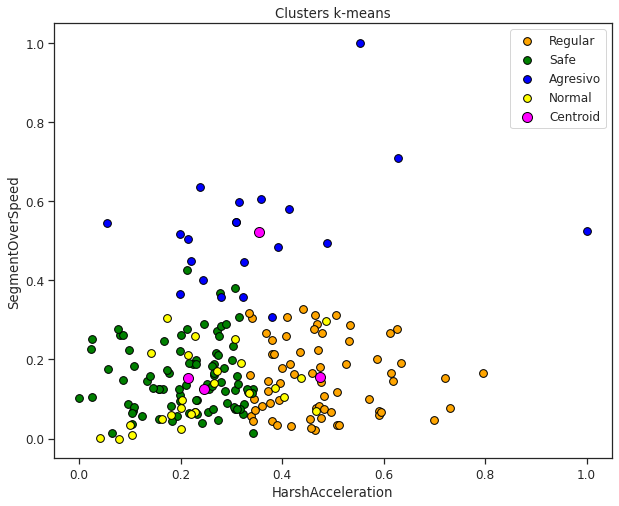

In [320]:
# Resultados del cluster
fig = plt.figure(figsize=(10, 8))
plt.scatter(dfTest.iloc[predict ==0, 0], dfTest.iloc[predict == 0, 1], color='orange', s=60, label='Regular', edgecolors='black')
plt.scatter(dfTest.iloc[predict == 1, 0], dfTest.iloc[predict == 1, 1], color='green', s=60, label='Safe', edgecolors='black')
plt.scatter(dfTest.iloc[predict == 2, 0], dfTest.iloc[predict == 2, 1], color='blue',s=60, label='Agresivo', edgecolors='black')
plt.scatter(dfTest.iloc[predict == 3, 0], dfTest.iloc[predict == 3, 1], color='yellow', s=60, label='Normal', edgecolors='black')

# cluster centres
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='magenta', s=100, label='Centroid',edgecolors='black')
plt.legend()
plt.title('Clusters k-means')
plt.ylabel('SegmentOverSpeed')
plt.xlabel('HarshAcceleration')
plt.show()

In [321]:
# Prueba del modelo
# Muestra debe ir en este orden: segmentOverSpeed, harshAcceleration, harshBraking, harshTurn, continuosDrivingMileage, cluster
sampleData=np.array([0.95,0.011,0.0000045,0.021,0.095,0.0])
sampleTest=sampleData.reshape(1, -1)
x = kmeans.predict(sampleTest)
print(x)

[0]


In [322]:
dfTest.head()

,0,1,2,3,4,cluster
0,0.399097,0.178312,0.000416,0.145620,0.122708,0
1,0.368924,0.266488,0.000000,0.122339,0.000000,0
2,0.391843,0.484984,0.000000,0.288899,0.142092,2
3,0.332142,0.116583,0.000000,0.058908,0.019880,1
4,0.277876,0.368396,0.000000,0.187927,0.118670,1


In [323]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [324]:
# centroide del cluster
print( kmeans.cluster_centers_)

[[4.75402247e-01 1.54703312e-01 1.18553366e-02 1.03214430e-01
  1.19835725e-01 1.33226763e-15]
 [2.14437145e-01 1.52701168e-01 2.92172922e-02 8.65905702e-02
  8.05023383e-02 3.00000000e+00]
 [3.54307603e-01 5.22711152e-01 4.05909874e-03 3.98068041e-01
  1.07252625e-01 1.00000000e+00]
 [2.46129524e-01 1.24059049e-01 9.70204723e-03 6.45411706e-02
  4.84685701e-01 2.00000000e+00]]


In [306]:
# Export archivo a formato xls
#dfTest.to_csv("kmeans.xls")

5. DBSCAN Model
   Clustering espacial basado en densidad para aplicaciones con ruido

In [452]:
# Clona template listo para incluir en el modelo
dfDBScan = dfTest
dfDBScan = dfDBScan.drop('cluster', 1)

In [727]:
# Reducción componente principal
X = dfDBScan.to_numpy()
decompositionDS = PCA(n_components = 3) 
mainX = decompositionDS.fit_transform(X) 
mainX = pd.DataFrame(mainX) 
mainX.columns = ['P1', 'P2','P3'] 
print(mainX.head())

         P1        P2        P3
0  0.045625 -0.017862  0.071769
1  0.118300 -0.116780  0.009228
2  0.319405  0.109487 -0.057117
3 -0.036349 -0.151438  0.036508
4  0.150142  0.031841 -0.108218


In [728]:
mainX.head()

,P1,P2,P3
0,0.045625,-0.017862,0.071769
1,0.118300,-0.116780,0.009228
2,0.319405,0.109487,-0.057117
3,-0.036349,-0.151438,0.036508
4,0.150142,0.031841,-0.108218


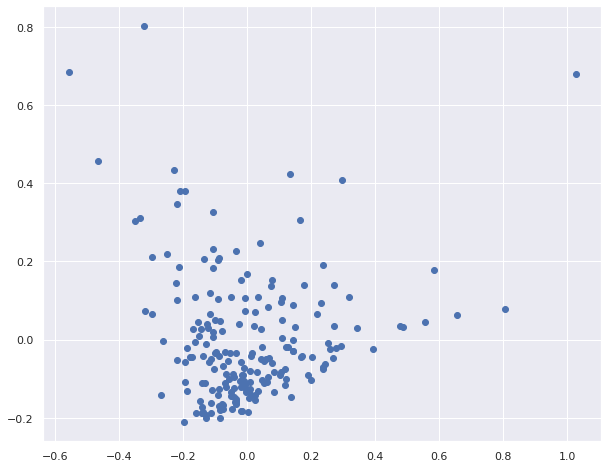

In [752]:
# Plot para ver distribución
arrayX = mainX.to_numpy()
fig = plt.figure(figsize=(10, 8))
plt.scatter(arrayX[:,0], arrayX[:,1])

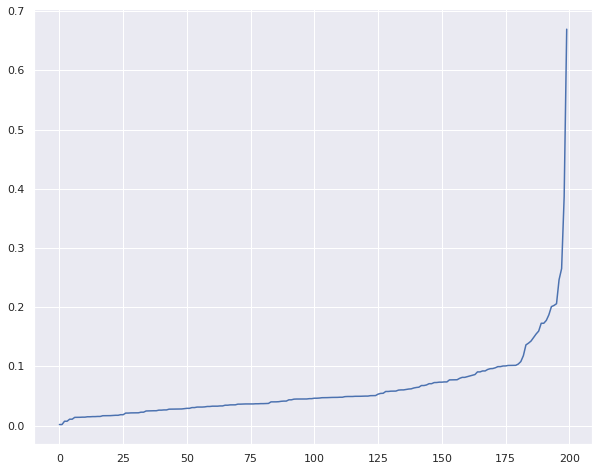

In [749]:
# Calcula el valor adecuado para eps
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(mainX)
distances, indices = nbrs.kneighbors(mainX)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
fig = plt.figure(figsize=(10, 8))
plt.plot(distances)

In [ ]:
# De acuerdo a la gráfica el valor de epsilon será el máximo punto de cobertura
# Para este caso eps = 0.11

In [742]:
# aplicamos el modelo
m = DBSCAN(eps=0.10, min_samples=5)
m.fit(mainX)
labels = m.labels_

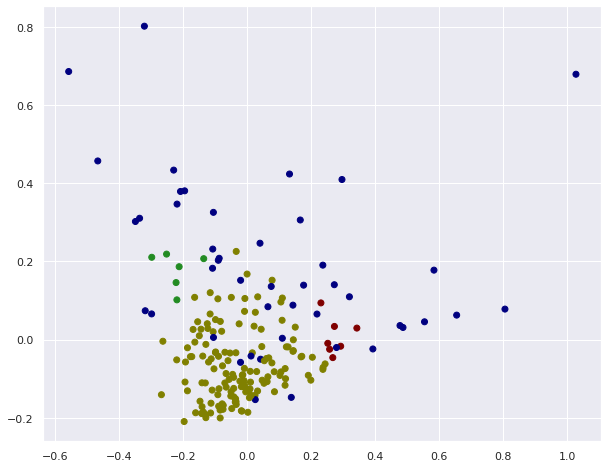

In [748]:
# Grafica los clusters resultantes
colors = ['olive', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
fig = plt.figure(figsize=(10, 8))
plt.scatter(arrayX[:,0], arrayX[:,1], c=vectorizer(labels))

In [746]:
# Obtiene número de clusters del modelo
clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('El número estimado de clusters: %d' % clusters_)

El número estimado de clusters: 3


In [747]:
score = silhouette_score(mainX, labels)
print("silhouette score : {})".format(score))

silhouette score : 0.08746102713111639)


6. Gaussian Cluster
   

In [645]:
# Clona template listo para incluir en el modelo
dfKnn = dfTest
dfKnn = dfKnn.drop('cluster', 1)

In [647]:
dfKnn.head()

,0,1,2,3,4
0,0.399097,0.178312,0.000416,0.145620,0.122708
1,0.368924,0.266488,0.000000,0.122339,0.000000
2,0.391843,0.484984,0.000000,0.288899,0.142092
3,0.332142,0.116583,0.000000,0.058908,0.019880
4,0.277876,0.368396,0.000000,0.187927,0.118670


In [769]:
# Define modelo
X = dfKnn.to_numpy()

model = AgglomerativeClustering(n_clusters=4)
model.fit(X)
result = model.fit_predict(X)

clusters = unique(result)


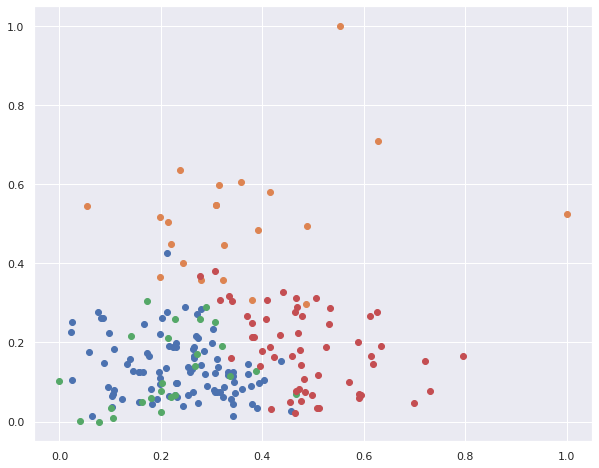

In [770]:
# Creación scatter plot para cada cluster
fig = plt.figure(figsize=(10, 8))
for cluster in clusters:
	ix = where(result == cluster)
	plt.scatter(X[ix, 0], X[ix, 1])


plt.show()

In [771]:
labels = model.labels_
score = silhouette_score(X, labels)
clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('El número estimado de clusters: %d' % clusters_)
print("silhouette score : {})".format(score))

El número estimado de clusters: 4
silhouette score : 0.2627026083459238)
